Run this notebook using the ``mncnh_sim`` environment

In [118]:
%load_ext autoreload
%autoreload 2

import pandas as pd, numpy as np, os
from vivarium import Artifact
import scipy.stats as stats
import scipy
from pathlib import Path

from ifa_gestational_age_shifts import lognorm_from_median_lower_upper, run_all_locations, load_mms_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# IFA/MMS Gestational Age Shift Calculation
Adapted from https://github.com/ihmeuw/vivarium_research_nutrition_optimization/blob/data_prep/data_prep/antenatal_interventions/Gestational%20age%20shifts.ipynb


For refactor, load LBWSG exposure from interactive sim without IV iron intervention

NOTE: The interactive sim is run below using a custom model spec with the oral iron intervention REMOVED.

In [119]:
! pip list | grep vivarium

vivarium                  3.6.3
vivarium_build_utils      2.0.13
vivarium_cluster_tools    2.1.25
vivarium_dependencies     1.0.1
vivarium_gates_mncnh      23.1.dev5+g49a87cb0b /mnt/share/homes/tylerdy/vivarium_gates_mncnh
vivarium_public_health    4.3.14
vivarium_testing_utils    0.2.6


In [120]:
! pip freeze | grep vivarium

vivarium==3.6.3
vivarium_build_utils==2.0.13
vivarium_cluster_tools==2.1.25
vivarium_dependencies==1.0.1
-e git+https://github.com/ihmeuw/vivarium_gates_mncnh.git@5454383fdb51ac778ead92de9ff2f408f60d303b#egg=vivarium_gates_mncnh
vivarium_public_health==4.3.14
vivarium_testing_utils==0.2.6


In [121]:
# note, got the list of draws that we actually use in the simulation from the concept model
# i think that we can only use these draws because we have incomplete data availability for the rest of them

# it actually looks like only the first 10 draws are working atm

draws_to_run = [115, 60, 118, 197, 79, 244, 22, 167, 146, 71]
    #28, 156, 94, 170, 109, 26, 35, 114, 178, 127]
ifa_shifts, exp_anc = run_all_locations(draws_to_run)

2026-01-23 10:07:04.914 | INFO     | simulation_22-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:07:04.917 | INFO     | simulation_22-artifact_manager:80 - Artifact base filter terms are ['draw == 115'].
2026-01-23 10:07:04.917 | INFO     | simulation_22-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:07:30.866 | WARNING  | simulation_22-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']
2026-01-23 10:07:30.867 | WARNING  | simulation_22-results_manager:446 - Specified excluded stratifications are already not included by default: ['stillbirth', 'partial_term']
2026-01-23 10:07:31.038 | WARNING  | simulation_22-values_manager:55 - Unsourced pipelines: ['iron_folic_acid_supplementation.exposure', 'multiple_micronutrient_supplementation.exposure']
2026-01-2

2026-01-23 10:07:32.571 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:07:34.001 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:07:35.386 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:07:36.178 | INFO     | simulation_22 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:07:44.209 | INFO     | simulation_23-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:07:44.210 | INFO     | simulation_23-artifact_manager:80 - Artifact base filter terms are ['draw == 60'].
2026-01-23 10:07:44.211 | INFO     | simulation_23-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:08:10.787 | WARNING  | simulation_23-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:08:12.479 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:08:13.875 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:08:14.937 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:08:15.658 | INFO     | simulation_23 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:08:24.766 | INFO     | simulation_24-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:08:24.768 | INFO     | simulation_24-artifact_manager:80 - Artifact base filter terms are ['draw == 118'].
2026-01-23 10:08:24.769 | INFO     | simulation_24-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:08:50.553 | WARNING  | simulation_24-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:08:52.261 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:08:53.646 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:08:54.727 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:08:55.453 | INFO     | simulation_24 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:09:03.315 | INFO     | simulation_25-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:09:03.316 | INFO     | simulation_25-artifact_manager:80 - Artifact base filter terms are ['draw == 197'].
2026-01-23 10:09:03.317 | INFO     | simulation_25-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:09:29.277 | WARNING  | simulation_25-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:09:30.983 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:09:32.382 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:09:33.445 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:09:34.217 | INFO     | simulation_25 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:09:42.659 | INFO     | simulation_26-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:09:42.661 | INFO     | simulation_26-artifact_manager:80 - Artifact base filter terms are ['draw == 79'].
2026-01-23 10:09:42.662 | INFO     | simulation_26-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:10:08.905 | WARNING  | simulation_26-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:10:10.637 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:10:12.034 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:10:13.113 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:10:13.835 | INFO     | simulation_26 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:10:22.660 | INFO     | simulation_27-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:10:22.661 | INFO     | simulation_27-artifact_manager:80 - Artifact base filter terms are ['draw == 244'].
2026-01-23 10:10:22.662 | INFO     | simulation_27-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:10:49.029 | WARNING  | simulation_27-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:10:50.739 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:10:52.129 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:10:53.161 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:10:53.890 | INFO     | simulation_27 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:11:01.824 | INFO     | simulation_28-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:11:01.825 | INFO     | simulation_28-artifact_manager:80 - Artifact base filter terms are ['draw == 22'].
2026-01-23 10:11:01.826 | INFO     | simulation_28-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:11:29.216 | WARNING  | simulation_28-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:11:30.946 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:11:32.366 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:11:33.407 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:11:34.164 | INFO     | simulation_28 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:11:42.215 | INFO     | simulation_29-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:11:42.217 | INFO     | simulation_29-artifact_manager:80 - Artifact base filter terms are ['draw == 167'].
2026-01-23 10:11:42.218 | INFO     | simulation_29-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:12:09.202 | WARNING  | simulation_29-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:12:10.927 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:12:12.331 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:12:13.384 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:12:14.101 | INFO     | simulation_29 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:12:22.514 | INFO     | simulation_30-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:12:22.515 | INFO     | simulation_30-artifact_manager:80 - Artifact base filter terms are ['draw == 146'].
2026-01-23 10:12:22.515 | INFO     | simulation_30-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:12:48.841 | WARNING  | simulation_30-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:12:50.518 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:12:51.905 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:12:52.925 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:12:53.645 | INFO     | simulation_30 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:13:01.776 | INFO     | simulation_31-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/ethiopia.hdf.
2026-01-23 10:13:01.777 | INFO     | simulation_31-artifact_manager:80 - Artifact base filter terms are ['draw == 71'].
2026-01-23 10:13:01.778 | INFO     | simulation_31-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:13:28.363 | WARNING  | simulation_31-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:13:30.094 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:13:31.516 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:13:32.558 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:13:33.277 | INFO     | simulation_31 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:13:43.996 | INFO     | simulation_32-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:13:43.997 | INFO     | simulation_32-artifact_manager:80 - Artifact base filter terms are ['draw == 115'].
2026-01-23 10:13:43.997 | INFO     | simulation_32-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:14:09.879 | WARNING  | simulation_32-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:14:11.687 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:14:13.139 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:14:14.202 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:14:14.946 | INFO     | simulation_32 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:14:23.552 | INFO     | simulation_33-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:14:23.553 | INFO     | simulation_33-artifact_manager:80 - Artifact base filter terms are ['draw == 60'].
2026-01-23 10:14:23.553 | INFO     | simulation_33-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:14:49.359 | WARNING  | simulation_33-results_manager:446 - Specified excluded stratifications are already not include

2026-01-23 10:14:51.063 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:14:52.469 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:14:53.514 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:14:54.242 | INFO     | simulation_33 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:15:02.528 | INFO     | simulation_34-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:15:02.529 | INFO     | simulation_34-artifact_manager:80 - Artifact base filter terms are ['draw == 118'].
2026-01-23 10:15:02.530 | INFO     | simulation_34-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:15:28.720 | WARNING  | simulation_34-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:15:30.423 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:15:31.823 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:15:32.877 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:15:33.623 | INFO     | simulation_34 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:15:42.958 | INFO     | simulation_35-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:15:42.960 | INFO     | simulation_35-artifact_manager:80 - Artifact base filter terms are ['draw == 197'].
2026-01-23 10:15:42.961 | INFO     | simulation_35-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:16:10.782 | WARNING  | simulation_35-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:16:12.550 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:16:14.079 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:16:15.152 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:16:15.882 | INFO     | simulation_35 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:16:24.363 | INFO     | simulation_36-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:16:24.364 | INFO     | simulation_36-artifact_manager:80 - Artifact base filter terms are ['draw == 79'].
2026-01-23 10:16:24.365 | INFO     | simulation_36-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:16:51.362 | WARNING  | simulation_36-results_manager:446 - Specified excluded stratifications are already not include

2026-01-23 10:16:53.077 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:16:54.465 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:16:55.491 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:16:56.216 | INFO     | simulation_36 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:17:03.953 | INFO     | simulation_37-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:17:03.954 | INFO     | simulation_37-artifact_manager:80 - Artifact base filter terms are ['draw == 244'].
2026-01-23 10:17:03.955 | INFO     | simulation_37-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:17:30.049 | WARNING  | simulation_37-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:17:31.970 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:17:33.996 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:17:35.316 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:17:36.392 | INFO     | simulation_37 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:17:44.550 | INFO     | simulation_38-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:17:44.553 | INFO     | simulation_38-artifact_manager:80 - Artifact base filter terms are ['draw == 22'].
2026-01-23 10:17:44.554 | INFO     | simulation_38-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:18:10.796 | WARNING  | simulation_38-results_manager:446 - Specified excluded stratifications are already not include

2026-01-23 10:18:12.509 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:18:13.900 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:18:14.921 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:18:15.643 | INFO     | simulation_38 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:18:24.742 | INFO     | simulation_39-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:18:24.743 | INFO     | simulation_39-artifact_manager:80 - Artifact base filter terms are ['draw == 167'].
2026-01-23 10:18:24.744 | INFO     | simulation_39-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:18:52.044 | WARNING  | simulation_39-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:18:53.745 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:18:55.290 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:18:56.390 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:18:57.112 | INFO     | simulation_39 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:19:04.857 | INFO     | simulation_40-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:19:04.858 | INFO     | simulation_40-artifact_manager:80 - Artifact base filter terms are ['draw == 146'].
2026-01-23 10:19:04.859 | INFO     | simulation_40-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:19:31.275 | WARNING  | simulation_40-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:19:32.962 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:19:34.399 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:19:35.558 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:19:36.280 | INFO     | simulation_40 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:19:44.736 | INFO     | simulation_41-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/nigeria.hdf.
2026-01-23 10:19:44.737 | INFO     | simulation_41-artifact_manager:80 - Artifact base filter terms are ['draw == 71'].
2026-01-23 10:19:44.738 | INFO     | simulation_41-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:20:10.607 | WARNING  | simulation_41-results_manager:446 - Specified excluded stratifications are already not include

2026-01-23 10:20:12.308 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:20:13.703 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:20:14.728 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:20:15.451 | INFO     | simulation_41 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:20:26.191 | INFO     | simulation_42-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:20:26.192 | INFO     | simulation_42-artifact_manager:80 - Artifact base filter terms are ['draw == 115'].
2026-01-23 10:20:26.193 | INFO     | simulation_42-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:20:54.736 | WARNING  | simulation_42-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:20:56.436 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:20:57.837 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:20:58.955 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:20:59.687 | INFO     | simulation_42 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:21:16.179 | INFO     | simulation_43-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:21:16.180 | INFO     | simulation_43-artifact_manager:80 - Artifact base filter terms are ['draw == 60'].
2026-01-23 10:21:16.181 | INFO     | simulation_43-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:21:45.037 | WARNING  | simulation_43-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:21:46.730 | INFO     | simulation_43 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:21:48.114 | INFO     | simulation_43 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:21:49.236 | INFO     | simulation_43 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:21:49.961 | INFO     | simulation_43 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:22:00.615 | INFO     | simulation_44-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:22:00.616 | INFO     | simulation_44-artifact_manager:80 - Artifact base filter terms are ['draw == 118'].
2026-01-23 10:22:00.617 | INFO     | simulation_44-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:22:28.462 | WARNING  | simulation_44-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:22:30.164 | INFO     | simulation_44 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:22:31.557 | INFO     | simulation_44 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:22:32.683 | INFO     | simulation_44 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:22:33.416 | INFO     | simulation_44 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:22:43.768 | INFO     | simulation_45-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:22:43.770 | INFO     | simulation_45-artifact_manager:80 - Artifact base filter terms are ['draw == 197'].
2026-01-23 10:22:43.771 | INFO     | simulation_45-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:23:10.737 | WARNING  | simulation_45-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:23:12.429 | INFO     | simulation_45 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:23:13.803 | INFO     | simulation_45 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:23:14.914 | INFO     | simulation_45 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:23:15.639 | INFO     | simulation_45 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:23:26.414 | INFO     | simulation_46-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:23:26.416 | INFO     | simulation_46-artifact_manager:80 - Artifact base filter terms are ['draw == 79'].
2026-01-23 10:23:26.416 | INFO     | simulation_46-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:23:52.437 | WARNING  | simulation_46-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:23:54.115 | INFO     | simulation_46 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:23:55.494 | INFO     | simulation_46 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:23:56.640 | INFO     | simulation_46 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:23:57.366 | INFO     | simulation_46 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:24:07.476 | INFO     | simulation_47-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:24:07.477 | INFO     | simulation_47-artifact_manager:80 - Artifact base filter terms are ['draw == 244'].
2026-01-23 10:24:07.478 | INFO     | simulation_47-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:24:35.531 | WARNING  | simulation_47-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:24:37.438 | INFO     | simulation_47 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:24:39.016 | INFO     | simulation_47 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:24:40.273 | INFO     | simulation_47 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:24:41.128 | INFO     | simulation_47 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:24:52.886 | INFO     | simulation_48-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:24:52.887 | INFO     | simulation_48-artifact_manager:80 - Artifact base filter terms are ['draw == 22'].
2026-01-23 10:24:52.888 | INFO     | simulation_48-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:25:22.539 | WARNING  | simulation_48-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:25:25.374 | INFO     | simulation_48 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:25:27.242 | INFO     | simulation_48 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:25:28.559 | INFO     | simulation_48 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:25:29.374 | INFO     | simulation_48 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:25:40.131 | INFO     | simulation_49-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:25:40.132 | INFO     | simulation_49-artifact_manager:80 - Artifact base filter terms are ['draw == 167'].
2026-01-23 10:25:40.133 | INFO     | simulation_49-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:26:19.008 | WARNING  | simulation_49-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:26:21.131 | INFO     | simulation_49 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:26:22.608 | INFO     | simulation_49 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:26:23.765 | INFO     | simulation_49 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:26:24.555 | INFO     | simulation_49 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:26:36.671 | INFO     | simulation_50-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:26:36.672 | INFO     | simulation_50-artifact_manager:80 - Artifact base filter terms are ['draw == 146'].
2026-01-23 10:26:36.673 | INFO     | simulation_50-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:27:15.600 | WARNING  | simulation_50-results_manager:446 - Specified excluded stratifications are already not inclu

2026-01-23 10:27:17.958 | INFO     | simulation_50 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:27:19.544 | INFO     | simulation_50 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:27:20.795 | INFO     | simulation_50 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:27:21.573 | INFO     | simulation_50 - vivarium.framework.engine:284 - 2025-01-04 00:00:00
2026-01-23 10:27:32.882 | INFO     | simulation_51-artifact_manager:79 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_gates_mncnh/artifacts/model22.0.2/pakistan.hdf.
2026-01-23 10:27:32.883 | INFO     | simulation_51-artifact_manager:80 - Artifact base filter terms are ['draw == 71'].
2026-01-23 10:27:32.884 | INFO     | simulation_51-artifact_manager:81 - Artifact additional filter terms are None.
2026-01-23 10:28:06.979 | WARNING  | simulation_51-results_manager:446 - Specified excluded stratifications are already not includ

2026-01-23 10:28:08.863 | INFO     | simulation_51 - vivarium.framework.engine:284 - 2025-01-01 00:00:00
2026-01-23 10:28:10.471 | INFO     | simulation_51 - vivarium.framework.engine:284 - 2025-01-02 00:00:00
2026-01-23 10:28:11.721 | INFO     | simulation_51 - vivarium.framework.engine:284 - 2025-01-03 00:00:00
2026-01-23 10:28:12.593 | INFO     | simulation_51 - vivarium.framework.engine:284 - 2025-01-04 00:00:00


In [123]:
ifa_shifts

,draw,location_id,shift_anc,shift_no_anc,rr_anc,rr_no_anc,rr_target
0,115,179,0.133384,0.284418,0.871308,0.871308,0.871306
1,60,179,0.100930,0.254491,0.887664,0.887663,0.887663
2,118,179,0.074472,0.218505,0.916496,0.916500,0.916497
3,197,179,0.090218,0.254263,0.898438,0.898439,0.898438
4,79,179,0.074730,0.186275,0.925882,0.925884,0.925883
5,244,179,0.085901,0.214851,0.908653,0.908658,0.908656
6,22,179,0.118737,0.288014,0.875800,0.875795,0.875796
7,167,179,0.080080,0.193147,0.918801,0.918802,0.918800
8,146,179,0.076688,0.201966,0.915439,0.915437,0.915438
9,71,179,0.111380,0.315146,0.877988,0.877986,0.877987


In [124]:
ifa_shifts.to_csv('ifa_ga_shifts.csv')

In [125]:
exp_anc

ga_start  \
anc1 parameter exposure draw     location rr       location_id ifa_coverage bw_start bw_end             
True cat52     0.179061 draw_115 ethiopia 0.871306 179         0.399308     3000     3500          38   
     cat44     0.110969 draw_115 ethiopia 0.871306 179         0.399308     2500     3000          38   
     cat54     0.108921 draw_115 ethiopia 0.871306 179         0.399308     3500     4000          38   
     cat48     0.100730 draw_115 ethiopia 0.871306 179         0.399308     3000     3500          37   
     cat42     0.083067 draw_115 ethiopia 0.871306 179         0.399308     2500     3000          37   
...                                                                                               ...   
     cat89     0.000651 draw_71  pakistan 0.877987 165         0.670925     3000     3500          30   
     cat8      0.000586 draw_71  pakistan 0.877987 165         0.670925     500      1000           0   
     cat46     0.000521 draw_71  pakistan 0.877987 165         0.670925     4000     9999          36   
     cat90     0.000391 draw_71  pakistan 0.877987 165         0.670925     3500     4000          30   
     cat14     0.000326 draw_71  pakistan 0.877987 165         0.670925     500      1000          30   

                                                                                             ga_end  
anc1 parameter exposure draw     location rr       location_id ifa_coverage bw_start bw_end          
True cat52     0.179061 draw_115 ethiopia 0.871306 179         0.399308     3000     3500        40  
     cat44     0.110969 draw_115 ethiopia 0.871306 179         0.399308     2500     3000        40  
     cat54     0.108921 draw_115 ethiopia 0.871306 179         0.399308     3500     4000        40  
     cat48     0.100730 draw_115 ethiopia 0.871306 179         0.399308     3000     3500        38  
     cat42     0.083067 draw_115 ethiopia 0.871306 179         0.399308     2500     3000        38  
...                                                                                             ...  
     cat89     0.000651 draw_71  pakistan 0.877987 165         0.670925     3000     3500        32  
     cat8      0.000586 draw_71  pakistan 0.877987 165         0.670925     500      1000        24  
     cat46     0.000521 draw_71  pakistan 0.877987 165         0.670925     4000     9999        37  
     cat90     0.000391 draw_71  pakistan 0.877987 165         0.670925     3500     4000        32  
     cat14     0.000326 draw_71  pakistan 0.877987 165         0.670925     500      1000        32  

[1730 rows x 2 columns]

In [126]:
exp_anc.to_csv('ifa_exp_anc.csv')

In [127]:
ifa_shifts = pd.read_csv('ifa_ga_shifts.csv').drop(columns='Unnamed: 0')
ifa_shifts

,draw,location_id,shift_anc,shift_no_anc,rr_anc,rr_no_anc,rr_target
0,115,179,0.133384,0.284418,0.871308,0.871308,0.871306
1,60,179,0.100930,0.254491,0.887664,0.887663,0.887663
2,118,179,0.074472,0.218505,0.916496,0.916500,0.916497
3,197,179,0.090218,0.254263,0.898438,0.898439,0.898438
4,79,179,0.074730,0.186275,0.925882,0.925884,0.925883
5,244,179,0.085901,0.214851,0.908653,0.908658,0.908656
6,22,179,0.118737,0.288014,0.875800,0.875795,0.875796
7,167,179,0.080080,0.193147,0.918801,0.918802,0.918800
8,146,179,0.076688,0.201966,0.915439,0.915437,0.915438
9,71,179,0.111380,0.315146,0.877988,0.877986,0.877987


In [130]:
exp_anc = pd.read_csv('ifa_exp_anc.csv')
exp_anc

,anc1,parameter,exposure,draw,location,rr,location_id,ifa_coverage,bw_start,bw_end,ga_start,ga_end
0,True,cat52,0.179061,draw_115,ethiopia,0.871306,179,0.399308,3000,3500,38,40
1,True,cat44,0.110969,draw_115,ethiopia,0.871306,179,0.399308,2500,3000,38,40
2,True,cat54,0.108921,draw_115,ethiopia,0.871306,179,0.399308,3500,4000,38,40
3,True,cat48,0.100730,draw_115,ethiopia,0.871306,179,0.399308,3000,3500,37,38
4,True,cat42,0.083067,draw_115,ethiopia,0.871306,179,0.399308,2500,3000,37,38
...,...,...,...,...,...,...,...,...,...,...,...,...
1725,True,cat89,0.000651,draw_71,pakistan,0.877987,165,0.670925,3000,3500,30,32
1726,True,cat8,0.000586,draw_71,pakistan,0.877987,165,0.670925,500,1000,0,24
1727,True,cat46,0.000521,draw_71,pakistan,0.877987,165,0.670925,4000,9999,36,37
1728,True,cat90,0.000391,draw_71,pakistan,0.877987,165,0.670925,3500,4000,30,32


In [161]:
# Function version of above code (left that for easier debugging if necessary)
data_mms_pt, data_mms_vpt, mms_pt_rr_draws, mms_vpt_rr_draws = load_mms_data(exp_anc.reset_index(), ifa_shifts)

In [162]:
display(data_mms_pt)
display(data_mms_vpt)
display(mms_pt_rr_draws)
display(mms_vpt_rr_draws)

,index,anc1,parameter,exposure,location,location_id,ifa_coverage,bw_start,bw_end,ga_start,ga_end,draw,frac_ptb,exposure_ptb,exposure_vptb,rr
0,0,True,cat52,0.179061,ethiopia,179,0.399308,3000,3500,38.062914,40.062914,draw_115,0.000000,0.000000,0.000000,0.921385
1,1,True,cat44,0.110969,ethiopia,179,0.399308,2500,3000,38.062914,40.062914,draw_115,0.000000,0.000000,0.000000,0.921385
2,2,True,cat54,0.108921,ethiopia,179,0.399308,3500,4000,38.062914,40.062914,draw_115,0.000000,0.000000,0.000000,0.921385
3,3,True,cat48,0.100730,ethiopia,179,0.399308,3000,3500,37.062914,38.062914,draw_115,0.000000,0.000000,0.000000,0.921385
4,4,True,cat42,0.083067,ethiopia,179,0.399308,2500,3000,37.062914,38.062914,draw_115,0.000000,0.000000,0.000000,0.921385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1725,True,cat89,0.000651,pakistan,165,0.670925,3000,3500,30.019993,32.019993,draw_71,1.000000,0.000651,0.000645,0.913209
1726,1726,True,cat8,0.000586,pakistan,165,0.670925,500,1000,0.019993,24.019993,draw_71,1.000000,0.000586,0.000586,0.913209
1727,1727,True,cat46,0.000521,pakistan,165,0.670925,4000,9999,36.019993,37.019993,draw_71,0.980007,0.000511,0.000000,0.913209
1728,1728,True,cat90,0.000391,pakistan,165,0.670925,3500,4000,30.019993,32.019993,draw_71,1.000000,0.000391,0.000387,0.913209


,index,anc1,parameter,exposure,location,location_id,ifa_coverage,bw_start,bw_end,ga_start,ga_end,draw,exposure_ptb,frac_vptb,exposure_vptb,rr
0,0,True,cat52,0.179061,ethiopia,179,0.399308,3000,3500,38.062914,40.062914,draw_115,0.000000,0.000000,0.000000,0.871358
1,1,True,cat44,0.110969,ethiopia,179,0.399308,2500,3000,38.062914,40.062914,draw_115,0.000000,0.000000,0.000000,0.871358
2,2,True,cat54,0.108921,ethiopia,179,0.399308,3500,4000,38.062914,40.062914,draw_115,0.000000,0.000000,0.000000,0.871358
3,3,True,cat48,0.100730,ethiopia,179,0.399308,3000,3500,37.062914,38.062914,draw_115,0.000000,0.000000,0.000000,0.871358
4,4,True,cat42,0.083067,ethiopia,179,0.399308,2500,3000,37.062914,38.062914,draw_115,0.000000,0.000000,0.000000,0.871358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,1725,True,cat89,0.000651,pakistan,165,0.670925,3000,3500,30.019993,32.019993,draw_71,0.000651,0.990003,0.000645,0.810886
1726,1726,True,cat8,0.000586,pakistan,165,0.670925,500,1000,0.019993,24.019993,draw_71,0.000586,1.000000,0.000586,0.810886
1727,1727,True,cat46,0.000521,pakistan,165,0.670925,4000,9999,36.019993,37.019993,draw_71,0.000511,0.000000,0.000000,0.810886
1728,1728,True,cat90,0.000391,pakistan,165,0.670925,3500,4000,30.019993,32.019993,draw_71,0.000391,0.990003,0.000387,0.810886


,draw,rr
0,draw_0,0.868700
1,draw_1,0.882736
2,draw_2,0.930161
3,draw_3,0.958324
4,draw_4,0.913703
...,...,...
995,draw_995,0.905300
996,draw_996,0.914963
997,draw_997,0.854333
998,draw_998,0.942922


,draw,rr
0,draw_0,0.796881
1,draw_1,0.858449
2,draw_2,0.823751
3,draw_3,0.806817
4,draw_4,0.793186
...,...,...
995,draw_995,0.777270
996,draw_996,0.784953
997,draw_997,0.891208
998,draw_998,0.779597


# Ok now for MMS

RR for preterm birth (37 weeks) relative to IFA: 0.91 (0.84, 0.99)... updated from: 0.95 (0.90, 1.01)

RR for very preterm birth (32 weeks) relative to IFA: 0.81 (0.71, 0.93)

In [163]:
def mms_shift(draw, location_id, ptb = True):
    if ptb:
        threshold = 'ptb'
        threshold_val = 37
        data = data_mms_pt.copy()
    else:
        threshold = 'vptb'
        threshold_val = 32
        data = data_mms_vpt.copy()
    exp_uncovered = data.loc[(data.draw==f'draw_{draw}')&(data.location_id==location_id)]
    uncovered_low = exp_uncovered[f'exposure_{threshold}'].sum()
    def shift_optimization(shift):
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered[f'frac_{threshold}'] = np.where(exp_covered.ga_start >= threshold_val, 0,
                                            np.where(exp_covered.ga_end < threshold_val, 1,
                                                    (threshold_val - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)
                                                    ))
        covered_low = (exp_covered.exposure * exp_covered[f'frac_{threshold}']).sum()
        rr = covered_low / uncovered_low
        return np.abs(rr - exp_covered.rr[0])
    return scipy.optimize.minimize_scalar(shift_optimization, bounds=(-2, 2), method='bounded')['x']

In [159]:
draw = 115
location_id = 179

mms_shift(draw, location_id, ptb = True)

0.27408711927001217

In [160]:
mms_shift(draw, location_id, ptb = False)

0.39652228955268976

In [72]:
# ok let's try some sort of joint approach?
    # first, apply the VPTB shift relative to IFA
    # then, for those who are not VPTB, find a new shift to correct for initial overestimate

In [164]:
def mms_double_shift(draw, location_id):
    
    ptb_rr = mms_pt_rr_draws.loc[mms_pt_rr_draws.draw==f'draw_{draw}'].rr.values[0]
    vptb_rr = mms_vpt_rr_draws.loc[mms_vpt_rr_draws.draw==f'draw_{draw}'].rr.values[0]
    
    exp_uncovered = data_mms_vpt.loc[(data_mms_vpt.draw==f'draw_{draw}')&(data_mms_vpt.location_id==location_id)]
    uncovered_vptb = exp_uncovered.exposure_vptb.sum()
    uncovered_ptb = exp_uncovered.exposure_ptb.sum()
    def vptb_shift_optimization(shift):
        exp_covered = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + shift
        exp_covered = exp_covered.reset_index()
        exp_covered['frac_vptb'] = np.where(exp_covered.ga_start >= 32, 0,
                                            np.where(exp_covered.ga_end < 32, 1,
                                                    (32 - exp_covered.ga_start)/(exp_covered.ga_end - exp_covered.ga_start)))
        covered_vptb = (exp_covered.exposure * exp_covered['frac_vptb']).sum()
        rr = covered_vptb / uncovered_vptb
        return np.abs(rr - vptb_rr)
    vptb_shift = scipy.optimize.minimize_scalar(vptb_shift_optimization, bounds=(-2, 2), method='bounded')['x']
    mms1 = exp_uncovered.set_index([c for c in exp_uncovered.columns if 'ga_' not in c]) + vptb_shift
    mms1 = mms1.reset_index()
    mms1['frac_vptb'] = np.where(mms1.ga_start >= 32, 0,
                                            np.where(mms1.ga_end < 32, 1,
                                                    (32 - mms1.ga_start)/(mms1.ga_end - mms1.ga_start)))
    mms1['frac_ptb'] = np.where(mms1.ga_start >= 37, 0,
                                            np.where(mms1.ga_end < 37, 1,
                                                    (37 - mms1.ga_start)/(mms1.ga_end - mms1.ga_start)))
    mms1_vptb = (mms1.exposure * mms1.frac_vptb).sum()
    mms1_ptb = (mms1.exposure * mms1.frac_ptb).sum()
    
    def second_shift_optimization(shift):
        mms2 = mms1.copy()
        mms2['ga_start'] = np.where(mms2.ga_start < (32 - shift), mms2.ga_start, mms2.ga_start + shift)
        mms2['ga_end'] = np.where(mms2.ga_start < (32 - shift), mms2.ga_end, mms2.ga_end + shift)
        mms2 = mms2.reset_index()
        mms2['frac_ptb'] = np.where(mms2.ga_start >= 37, 0,
                                            np.where(mms2.ga_end < 37, 1,
                                                    (37 - mms2.ga_start)/(mms2.ga_end - mms2.ga_start)))
        mms2['frac_vptb'] = np.where(mms2.ga_start >= 32, 0,
                                            np.where(mms2.ga_end < 32, 1,
                                                    (32 - mms2.ga_start)/(mms2.ga_end - mms2.ga_start)))
        mms2_ptb = (mms2.exposure * mms2['frac_ptb']).sum()
        mms2_vptb = (mms2.exposure * mms2.frac_vptb).sum()
        rr = mms2_ptb / uncovered_ptb
        return np.abs(rr - ptb_rr)
    second_shift = scipy.optimize.minimize_scalar(second_shift_optimization, bounds=(-5, 5), method='bounded')['x']
    
    return vptb_shift, second_shift

In [165]:
mms_double_shift(draw, location_id)

(0.39652228955268976, -0.12243669688149744)

In [75]:
# rules for applying MMS shifts:
    # apply first shift to everyone who gets MMS
    # if their shifted GA is greater than (32 + second_shift):
        # apply the second shift
    # otherwise, that's their final GA

In [76]:
ethiopia_mms_shifts = pd.DataFrame()
for draw in list(range(0,n_draws)):
    shift1, shift2 = mms_double_shift(draw, 179)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    ethiopia_mms_shifts = pd.concat([ethiopia_mms_shifts, temp], ignore_index=True)
ethiopia_mms_shifts

,draw,shift1,shift2
0,draw_0,0.661335,-0.151295
1,draw_1,0.467092,-0.013965
2,draw_2,0.606925,-0.337975
3,draw_3,0.617615,-0.456241
4,draw_4,0.682057,-0.364714
...,...,...,...
245,draw_245,0.214998,0.228765
246,draw_246,0.193381,0.327616
247,draw_247,0.748733,-0.605413
248,draw_248,0.580686,-0.339876


In [77]:
ethiopia_mms_shifts.describe()

,shift1,shift2
count,250.000000,250.000000
mean,0.596890,-0.257014
std,0.186001,0.233080
min,-0.051074,-0.932749
25%,0.481829,-0.402020
50%,0.602100,-0.275364
75%,0.717470,-0.107379
max,1.094999,0.380081


In [78]:
location_id=214
nigeria_mms_shifts = pd.DataFrame()
for draw in list(range(0,n_draws)):
    shift1, shift2 = mms_double_shift(draw, location_id)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    nigeria_mms_shifts = pd.concat([nigeria_mms_shifts, temp], ignore_index=True)
nigeria_mms_shifts['location_id'] = location_id
nigeria_mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.683740,-0.172267,214
1,draw_1,0.477906,-0.012800,214
2,draw_2,0.598573,-0.324794,214
3,draw_3,0.642979,-0.478185,214
4,draw_4,0.706030,-0.363492,214
...,...,...,...,...
245,draw_245,0.226788,0.231589,214
246,draw_246,0.197303,0.332516,214
247,draw_247,0.800769,-0.651901,214
248,draw_248,0.573571,-0.323586,214


In [79]:
nigeria_mms_shifts.describe(percentiles=[0.025,0.975])

,shift1,shift2,location_id
count,250.000000,250.000000,250.0
mean,0.605825,-0.256072,214.0
std,0.187753,0.235590,0.0
min,-0.049604,-0.966323,214.0
2.5%,0.200723,-0.740559,214.0
50%,0.614651,-0.267541,214.0
97.5%,0.962506,0.224496,214.0
max,1.133516,0.388841,214.0


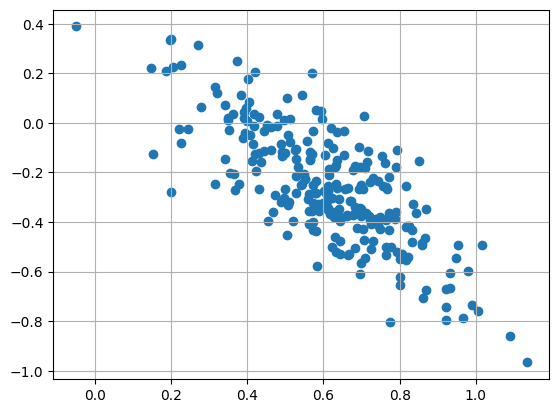

In [80]:
plt.scatter(nigeria_mms_shifts.shift1, nigeria_mms_shifts.shift2)
plt.grid()

In [81]:
location_id=165
pakistan_mms_shifts = pd.DataFrame()
for draw in list(range(0,n_draws)):
    shift1, shift2 = mms_double_shift(draw, location_id)
    temp = pd.DataFrame()
    temp['draw'] = [f'draw_{draw}']
    temp['shift1'] = [shift1]
    temp['shift2'] = [shift2]
    pakistan_mms_shifts = pd.concat([pakistan_mms_shifts, temp], ignore_index=True)
pakistan_mms_shifts['location_id'] = location_id
pakistan_mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.711276,-0.208753,165
1,draw_1,0.497675,-0.032594,165
2,draw_2,0.590892,-0.328295,165
3,draw_3,0.690796,-0.525301,165
4,draw_4,0.712022,-0.383473,165
...,...,...,...,...
245,draw_245,0.243085,0.218325,165
246,draw_246,0.201008,0.319427,165
247,draw_247,0.833164,-0.681182,165
248,draw_248,0.609780,-0.364152,165


In [82]:
ethiopia_mms_shifts['location_id'] = 179
mms_shifts = pd.concat([ethiopia_mms_shifts,
                       nigeria_mms_shifts,
                       pakistan_mms_shifts], ignore_index=True)
mms_shifts

,draw,shift1,shift2,location_id
0,draw_0,0.661335,-0.151295,179
1,draw_1,0.467092,-0.013965,179
2,draw_2,0.606925,-0.337975,179
3,draw_3,0.617615,-0.456241,179
4,draw_4,0.682057,-0.364714,179
...,...,...,...,...
745,draw_245,0.243085,0.218325,165
746,draw_246,0.201008,0.319427,165
747,draw_247,0.833164,-0.681182,165
748,draw_248,0.609780,-0.364152,165


In [83]:
mms_shifts.to_csv('updated_mms_shifts.csv')

In [84]:
covered_exp

,location_id,age_group_id,sex_id,parameter,ga_start,ga_end,bw_start,bw_end,draw,exposure,covered_shift,frac_ptb,exposure_ptb,frac_vptb,exposure_vptb
0,214,164,1,cat2,0.054992,24.054992,0,500,draw_0,0.000764,0.054992,1.0,0.000764,1.0,0.000764
1,214,164,2,cat2,0.054992,24.054992,0,500,draw_0,0.000585,0.054992,1.0,0.000585,1.0,0.000585
2,214,164,1,cat8,0.054992,24.054992,500,1000,draw_0,0.000782,0.054992,1.0,0.000782,1.0,0.000782
3,214,164,2,cat8,0.054992,24.054992,500,1000,draw_0,0.000851,0.054992,1.0,0.000851,1.0,0.000851
4,214,164,1,cat10,24.054992,26.054992,500,1000,draw_0,0.000558,0.054992,1.0,0.000558,1.0,0.000558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86995,165,164,1,cat116,38.039735,40.039735,1000,1500,draw_249,0.009025,0.039735,0.0,0.000000,0.0,0.000000
86996,165,164,2,cat117,38.039735,40.039735,1500,2000,draw_249,0.017519,0.039735,0.0,0.000000,0.0,0.000000
86997,165,164,1,cat117,38.039735,40.039735,1500,2000,draw_249,0.016403,0.039735,0.0,0.000000,0.0,0.000000
86998,165,164,2,cat123,40.039735,42.039735,1500,2000,draw_249,0.004597,0.039735,0.0,0.000000,0.0,0.000000


In [85]:
# ok, now for some validation
mms_exp_val = covered_exp.merge(mms_shifts, on=['draw','location_id'])
mms_exp_val['ga_start'] = mms_exp_val.ga_start + mms_exp_val.shift1
mms_exp_val['ga_end'] = mms_exp_val.ga_end + mms_exp_val.shift1
mms_exp_val['frac_shift2'] = np.where(mms_exp_val.ga_start < (32 - mms_exp_val.shift2), 0, 1)
mms_exp_val['ga_start'] = mms_exp_val.ga_start + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)
mms_exp_val['ga_end'] = mms_exp_val.ga_end + (mms_exp_val.shift2 * mms_exp_val.frac_shift2)

mms_exp_val['exposure_vptb'] = np.where(mms_exp_val.ga_start >= 32, 0,
                                            np.where(mms_exp_val.ga_end < 32, mms_exp_val.exposure,
                                                    ((32 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                     * mms_exp_val.exposure)))
mms_exp_val['exposure_ptb'] = np.where(mms_exp_val.ga_start >= 37, 0,
                                        np.where(mms_exp_val.ga_end < 37, mms_exp_val.exposure,
                                                ((37 - mms_exp_val.ga_start)/(mms_exp_val.ga_end - mms_exp_val.ga_start)
                                                 *mms_exp_val.exposure)))
mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
mms_exp_val

/tmp/ipykernel_2106044/996656630.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mms_exp_val = mms_exp_val.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]


exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_0        0.283901       0.050903
            draw_1        0.281859       0.052229
            draw_10       0.306069       0.054389
            draw_100      0.282966       0.050222
            draw_101      0.305432       0.048175
...                            ...            ...
214         draw_95       0.296743       0.046972
            draw_96       0.288469       0.048798
            draw_97       0.300346       0.048657
            draw_98       0.301221       0.051032
            draw_99       0.272026       0.051868

[750 rows x 2 columns]

In [86]:
rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]
rrs

/tmp/ipykernel_2106044/3982770509.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rrs = mms_exp_val / covered_exp.groupby(['location_id','draw']).sum()[['exposure_ptb','exposure_vptb']]


exposure_ptb  exposure_vptb
location_id draw                                 
165         draw_0        0.868700       0.796881
            draw_1        0.882736       0.858449
            draw_10       0.941235       0.828063
            draw_100      0.904064       0.853372
            draw_101      0.930720       0.759672
...                            ...            ...
214         draw_95       0.916759       0.782767
            draw_96       0.898073       0.818430
            draw_97       0.926025       0.812167
            draw_98       0.925693       0.842114
            draw_99       0.842710       0.874795

[750 rows x 2 columns]

In [87]:
print('Validation target is: ',mms_pt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_pt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_pt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_ptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.912  (95% CI:  0.84 ,  0.987 )


mean     0.911362
2.5%     0.841377
97.5%    0.981787
Name: exposure_ptb, dtype: float64

In [88]:
print('Validation target is: ',mms_vpt_rr_draws.rr.mean().round(3),
      ' (95% CI: ',mms_vpt_rr_draws.rr.quantile(0.025).round(3), 
      ", ",mms_vpt_rr_draws.rr.quantile(0.975).round(3), ")")
rrs.describe(percentiles=[0.025,0.975]).exposure_vptb.filter(['mean','2.5%','97.5%'])

Validation target is:  0.813  (95% CI:  0.706 ,  0.936 )


mean     0.819582
2.5%     0.713342
97.5%    0.939751
Name: exposure_vptb, dtype: float64